# Bibliotecas

In [422]:
# ! pip install statsmodels -U
# ! pip install pmdarima
# ! pip install ptitprince
# ! pip install xgboost
# ! pip install sktime

In [423]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ptitprince as pt
import xgboost as xgb
import datetime as dt

from pmdarima.arima import (ndiffs,
                            auto_arima)
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import (plot_acf,
                                           plot_pacf)
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (mean_squared_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error)
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA

# Dataset

In [424]:
# data_dir = '/content/drive/MyDrive/Datasets/NASA Acoustics and Vibration Database/2nd_test/2nd_test'
# df_rolamento = pd.DataFrame()

# for filename in os.listdir(data_dir):
#     dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
#     dataset_mean_abs = np.array(dataset.abs().mean())
#     dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
#     dataset_mean_abs.index = [filename]
#     df_rolamento = df_rolamento.append(dataset_mean_abs)

# df_rolamento.columns = ['bearing_1','bearing_2','bearing_3','bearing_4']



# df_rolamento.index = pd.to_datetime(df_rolamento.index,
#                                     format='%Y.%m.%d.%H.%M.%S').sort_values()

# df_rolamento

In [425]:
# df_rolamento.to_csv('/content/drive/MyDrive/Datasets/NASA Acoustics and Vibration Database/df_rolamento_2nd_test.csv',
#                     sep=',',
#                     encoding='utf-8',
#                     columns=['bearing_1','bearing_2','bearing_3','bearing_4'],
#                     index_label='t_stamp')

In [426]:
df_rolamento = pd.read_csv('/content/drive/MyDrive/Datasets/NASA Acoustics and Vibration Database/df_rolamento_2nd_test.csv',
                           sep=',',
                           encoding='utf-8')

df_rolamento.index = pd.to_datetime(df_rolamento['t_stamp'],
                                    format='%Y-%m-%d %H:%M:%S').sort_values()

df_rolamento = pd.DataFrame(df_rolamento['bearing_1'])

# df_rolamento

## Limite superior df_rolamento

### 3 sigma

In [427]:
media = df_rolamento.mean()[0]

desv_pad = df_rolamento.std()[0]

lim_sup_sigma = 3 * desv_pad + media

lim_sup_sigma

0.201419741180899

### Boxplot

In [428]:
primeiro_q = df_rolamento.describe().loc['25%'][0]

terceiro_q = df_rolamento.describe().loc['75%'][0]

lim_sup_boxplot = terceiro_q + 1.5 * (terceiro_q - primeiro_q)

lim_sup_boxplot

0.11690946213193988

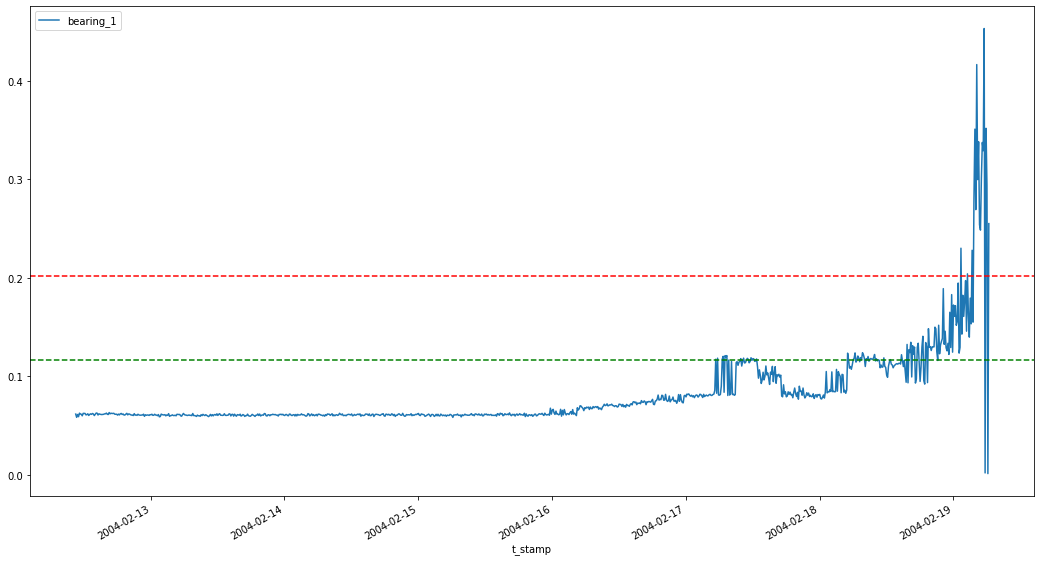

In [429]:
fig, ax = plt.subplots()

df_rolamento.plot(ax=ax, figsize=(18,10))

ax.axhline(lim_sup_sigma, color='r', linestyle='--')

ax.axhline(lim_sup_boxplot, color='green', linestyle='--')

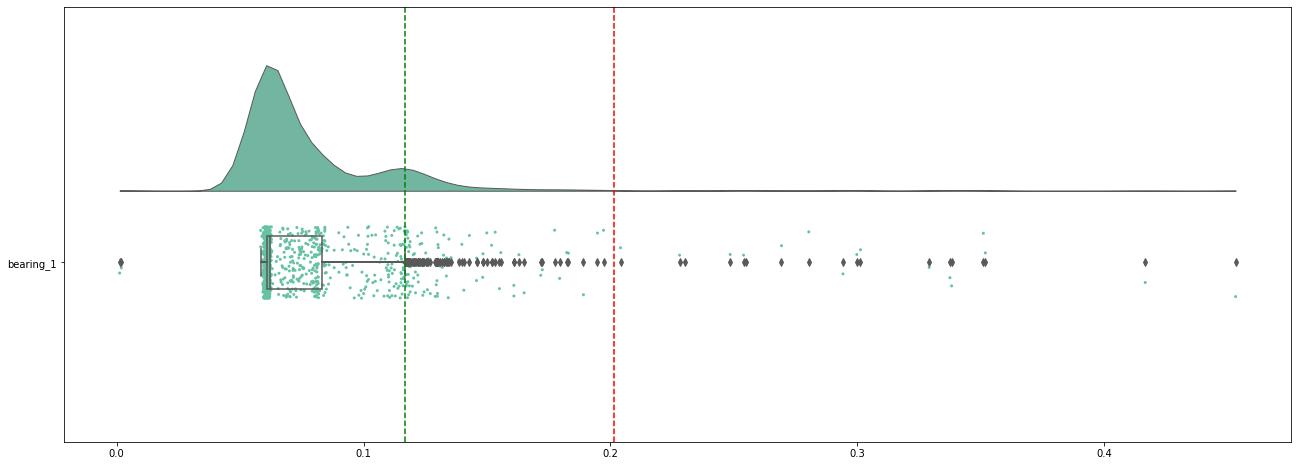

In [430]:
ax = pt.RainCloud(data=df_rolamento,
                  orient='h')

ax.axvline(lim_sup_sigma, color='r', linestyle='--')

ax.axvline(lim_sup_boxplot, color='green', linestyle='--')

ax.figure.set_size_inches(22,8)

## Dataset pré-falha

In [431]:
df_pre_falha = df_rolamento.copy()

# Identifica qual o primeiro timestamp onde o limite é ultrapassado
# O dataset pre_falha vai até este valor
df_pre_falha.loc[(df_pre_falha.index >= '2004-02-18 00:02:39') & (df_pre_falha['bearing_1'] >= lim_sup_boxplot)]

,bearing_1
t_stamp,
2004-02-18 05:02:39,0.123535
2004-02-18 06:02:39,0.116939
2004-02-18 06:12:39,0.118338
2004-02-18 06:22:39,0.123793
2004-02-18 06:52:39,0.120616
...,...
2004-02-19 05:22:39,0.329182
2004-02-19 05:32:39,0.453335
2004-02-19 05:52:39,0.351952


In [432]:
df_pre_falha = df_pre_falha.loc[df_pre_falha.index <= '2004-02-18 05:02:39']

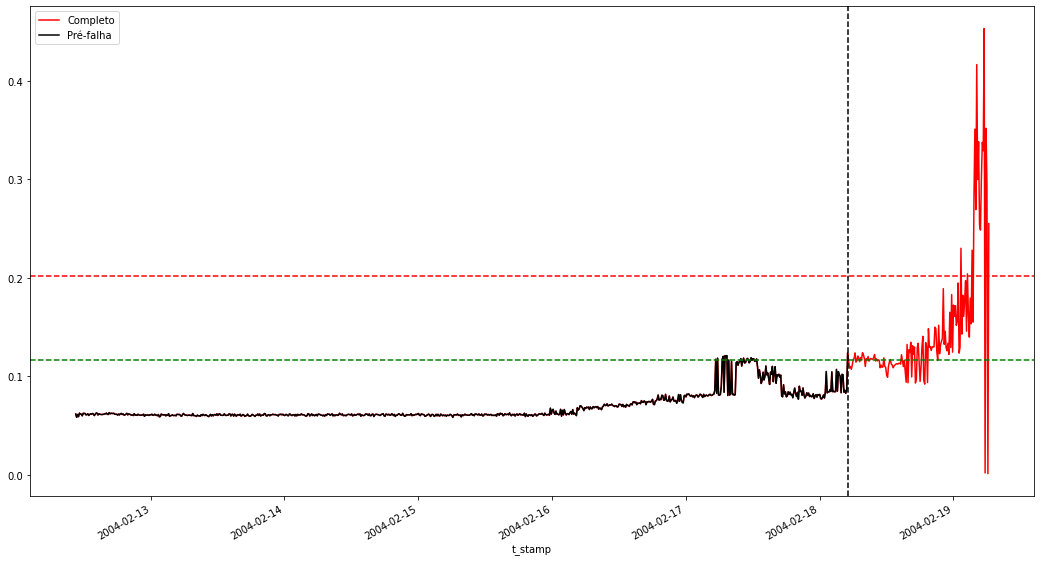

In [433]:
fig, ax = plt.subplots(figsize=(18,10))

df_rolamento.plot(ax=ax, color='red')

df_pre_falha.plot(ax=ax, color='k')

ax.axhline(lim_sup_sigma, color='r', linestyle='--')

ax.axhline(lim_sup_boxplot, color='green', linestyle='--')

ax.axvline(pd.to_datetime('2004-02-18 05:02:39'), color='k', linestyle='--')

ax.legend(labels=['Completo', 'Pré-falha'])

### 3 sigma

In [434]:
# media_df_pre_falha = df_pre_falha.mean()[0]

# media_df_pre_falha

In [435]:
# desv_pad_df_pre_falha = df_pre_falha.std()[0]

# desv_pad_df_pre_falha

In [436]:
# lim_sup_sigma_pre_falha = 3 * desv_pad_df_pre_falha + media_df_pre_falha

# lim_sup_sigma_pre_falha

### Boxplot

In [437]:
# primeiro_q = df_pre_falha.describe().loc['25%'][0]

# terceiro_q = df_pre_falha.describe().loc['75%'][0]

# lim_sup_boxplot_pre_falha = terceiro_q + 1.5 * (terceiro_q - primeiro_q)

# lim_sup_boxplot_pre_falha

In [438]:
# ax = pt.RainCloud(data=df_pre_falha,
#                   orient='h')

# ax.axvline(lim_sup_sigma_pre_falha, color='r', linestyle='--')

# ax.axvline(lim_sup_boxplot_pre_falha, color='green', linestyle='--')

# ax.figure.set_size_inches(22,8)

# Teste de estacionariedade

## Teste de Dickey-Fuller

In [439]:
stat_t = adfuller(df_pre_falha.dropna())[0]
p_valor = adfuller(df_pre_falha.dropna())[1]

valor_critico_1 = adfuller(df_pre_falha.dropna())[4].get('1%')
valor_critico_5 = adfuller(df_pre_falha.dropna())[4].get('5%')
valor_critico_10 = adfuller(df_pre_falha.dropna())[4].get('10%')

significancia= 0.05
# Se a significância for 1% ou 10% é necessário
# alterar a condicional no if

if valor_critico_5 <= stat_t and significancia <= p_valor:
    print('Hipótese nula aceita'
          '\nSérie temporal não estacionária')
else:
    print('Hipótese nula rejeitada'
          '\nSérie temporal estacionária')

Hipótese nula aceita
Série temporal não estacionária


In [440]:
adfuller(df_pre_falha.dropna())

(-0.636884991967609,
 0.8624278529797049,
 17,
 814,
 {'1%': -3.4384090190455994,
  '5%': -2.865097201355259,
  '10%': -2.5686641656756155},
 -6429.089524606168)

## Autocorrelação

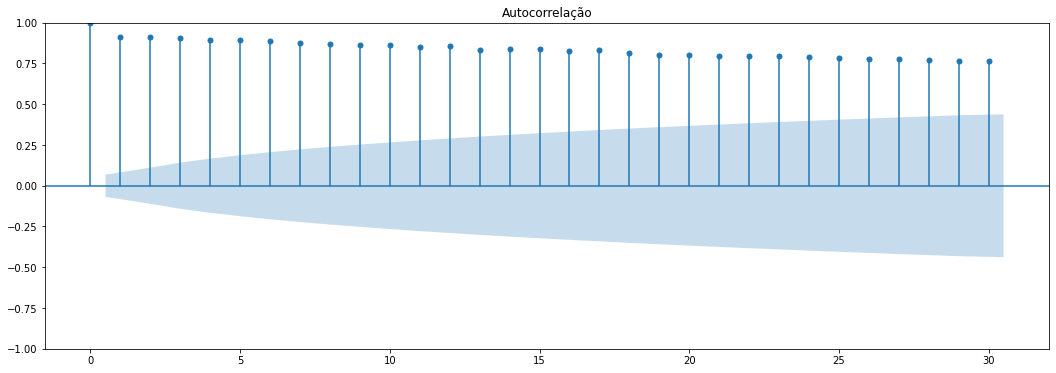

In [441]:
autocorr = plot_acf(df_pre_falha, title='Autocorrelação')
autocorr.set_figheight(6)
autocorr.set_figwidth(18)
plt.show()

## Autocorrelação parcial

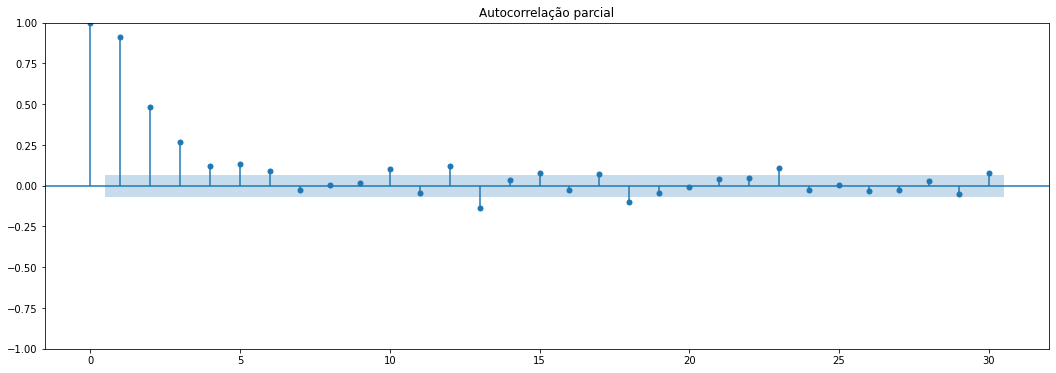

In [442]:
autocorr_parc = plot_pacf(df_pre_falha,
                          title='Autocorrelação parcial',
                          method='ywm')
autocorr_parc.set_figheight(6)
autocorr_parc.set_figwidth(18)
plt.show()

# ARIMA

## Diferenciação

In [443]:
ndiffs(df_pre_falha, test='adf')

1

## Parâmetros p, d, q

In [444]:
auto_arima = auto_arima(df_pre_falha)

auto_arima

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [445]:
modelo = ARIMA(endog=df_pre_falha,
               order=(0, 1, 1),
               freq='10min')

results = modelo.fit()

# print(results.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


## Análise dos resíduos

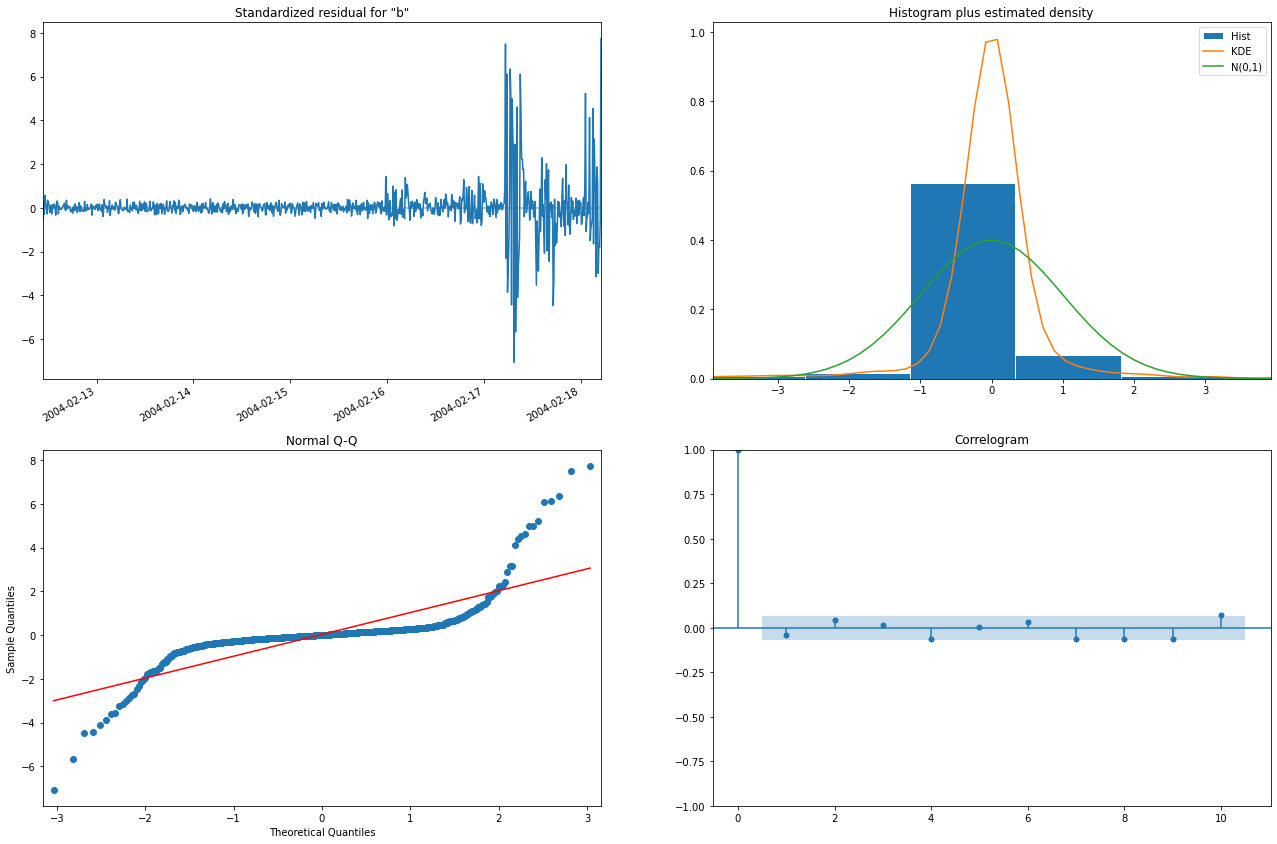

In [446]:
results.plot_diagnostics(figsize=(22,16));

# Previsão de valores



## Treino e teste

In [447]:
tam_treino = int(round(len(df_pre_falha) * 0.7, 0)) # 70% do dataset pre_falha para treino

In [448]:
train = df_pre_falha.iloc[:tam_treino]

test = df_pre_falha.iloc[tam_treino:]

## Interpolação

#### Modelo de previsão

In [449]:
pred = results.get_prediction(start=test.index[0],
                              dynamic=False)

y_pred = pred.predicted_mean

### Intervalo de confiança

In [450]:
pred_ic = pred.conf_int()

### Análise gráfica

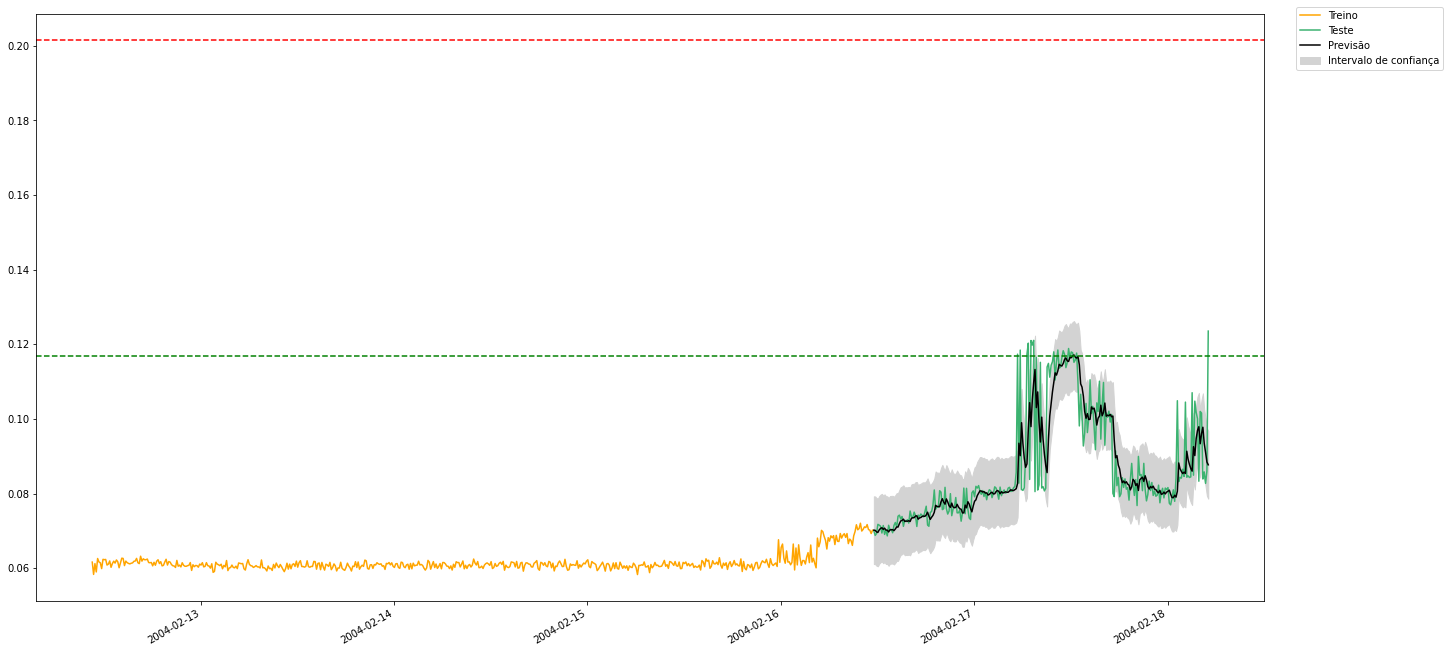

In [451]:
fig, ax = plt.subplots(figsize=(22,12))

train.plot(ax=ax, color='orange')

test.plot(ax=ax, color='mediumseagreen')

y_pred.plot(ax=ax, color='k')

ax.fill_between(pred_ic.index,
                pred_ic.iloc[:, 0],
                pred_ic.iloc[:, 1],
                color='lightgrey')

ax.legend(labels=['Treino',
                  'Teste',
                  'Previsão',
                  'Intervalo de confiança'],
                   bbox_to_anchor=(1.15, 1.02))

ax.set_xlabel(None)
# ax.set_xlim(pd.to_datetime('2004-02-17'))

# ax.set_ylim(0, 0.5)

ax.axhline(lim_sup_sigma, color='r', linestyle='--')

ax.axhline(lim_sup_boxplot, color='green', linestyle='--')

# ax.annotate(s='threshold ➜ ' + str(lim_sup_boxplot_pre_falha.round(2)),
#             xy=(pd.to_datetime('2004-02-19'), lim_sup_boxplot_pre_falha),
#             xytext=(pd.to_datetime('2004-02-19 06:02:39'), lim_sup_boxplot_pre_falha + 0.005),
#             color='r')

# ax.annotate(s='threshold ➜ ' + str(lim_sup_sigma_pre_falha.round(2)),
#             xy=(pd.to_datetime('2004-02-19'), lim_sup_sigma_pre_falha),
#             xytext=(pd.to_datetime('2004-02-19 06:02:39'), lim_sup_sigma_pre_falha + 0.005),

### Acurácia do modelo

#### Raiz do erro quadrático médio

In [452]:
rmse = sqrt(mean_squared_error(test, y_pred))

rmse

0.008275523183952882

#### Coeficiente de determinação (r²)

In [453]:
r_squared = r2_score(test, y_pred)

r_squared

0.6838920366415691

#### Erro médio absoluto

In [454]:
mae = mean_absolute_error(test, y_pred)

mae

0.004853136152604866

## Extrapolação

In [455]:
pred_uc = results.get_forecast(steps=24) # Cada passo deve ser considerado 10 min

# Steps
# 6 = 1 h
# 12 = 2 h
# 18 = 3 h
# 24 = 4 h

y_forecast = pred_uc.predicted_mean

### Intervalo de confiança

In [456]:
pred_ic = pred_uc.conf_int()

### Análise gráfica

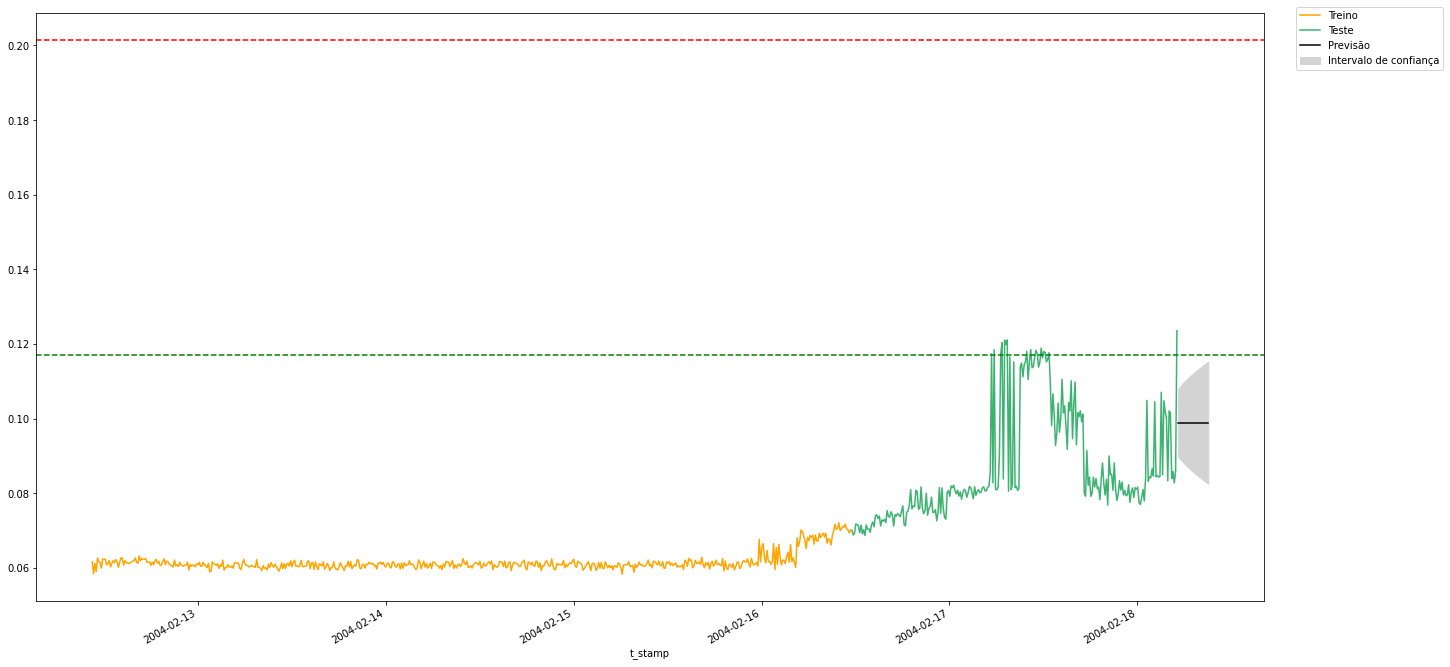

In [457]:
fig, ax = plt.subplots(figsize=(22, 12))

train.plot(ax=ax, color='orange')

test.plot(ax=ax, color='mediumseagreen')

y_forecast.plot(ax=ax, color='k')

ax.fill_between(pred_ic.index,
                pred_ic.iloc[:, 0],
                pred_ic.iloc[:, 1],
                color='lightgrey')

ax.legend(labels=['Treino', 'Teste', 'Previsão', 'Intervalo de confiança'],
          bbox_to_anchor=(1.15, 1.02))

ax.axhline(lim_sup_sigma, color='r', linestyle='--')

ax.axhline(lim_sup_boxplot, color='green', linestyle='--')

# Comparativo com dados reais

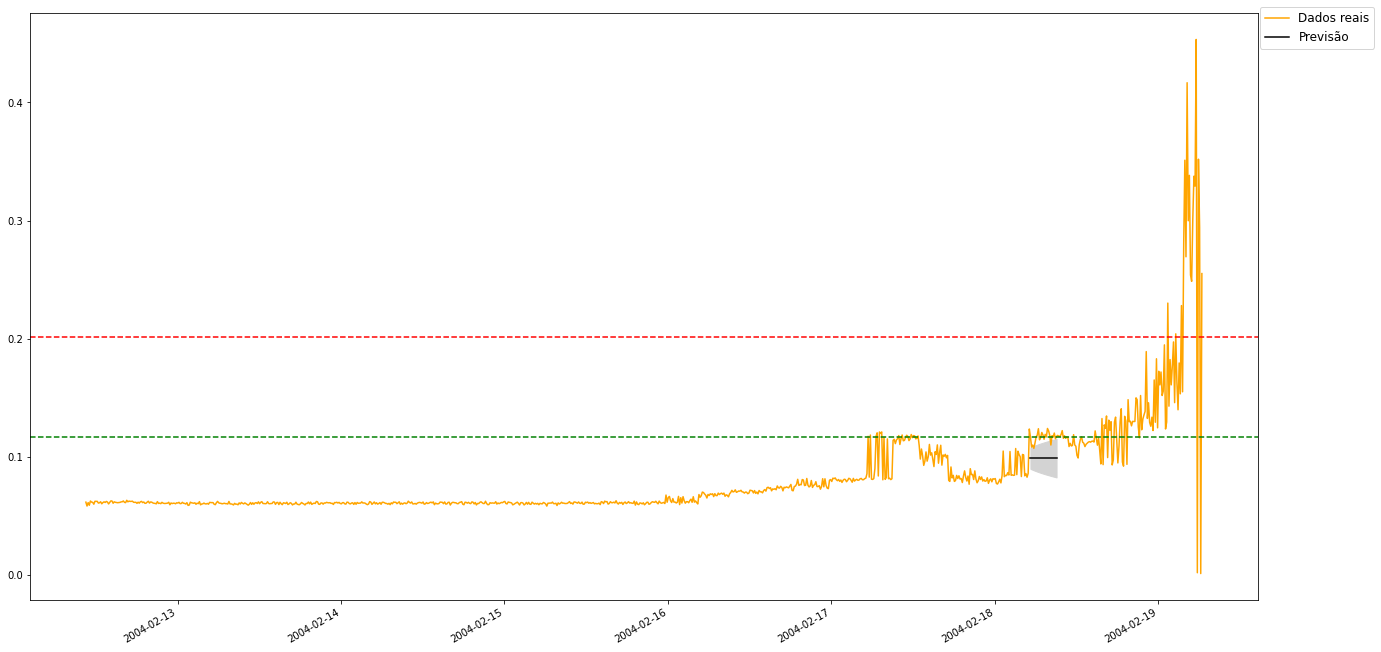

In [458]:
fig, ax = plt.subplots(figsize=(22,12))

df_rolamento.plot(ax=ax, color='orange')

ax.set_xlabel(None)

y_forecast.plot(ax=ax, color='k')

ax.fill_between(pred_ic.index,
                pred_ic.iloc[:, 0],
                pred_ic.iloc[:, 1],
                color='lightgrey')

ax.axhline(lim_sup_sigma, color='r', linestyle='--')

ax.axhline(lim_sup_boxplot, color='green', linestyle='--')

ax.legend(labels=['Dados reais', 'Previsão'],
          bbox_to_anchor=(1.1, 1.02),
          fontsize=12)

# XGBoost

In [459]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.hour
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

## Cross validation

In [460]:
df_pre_falha_xgb = df_pre_falha.copy()

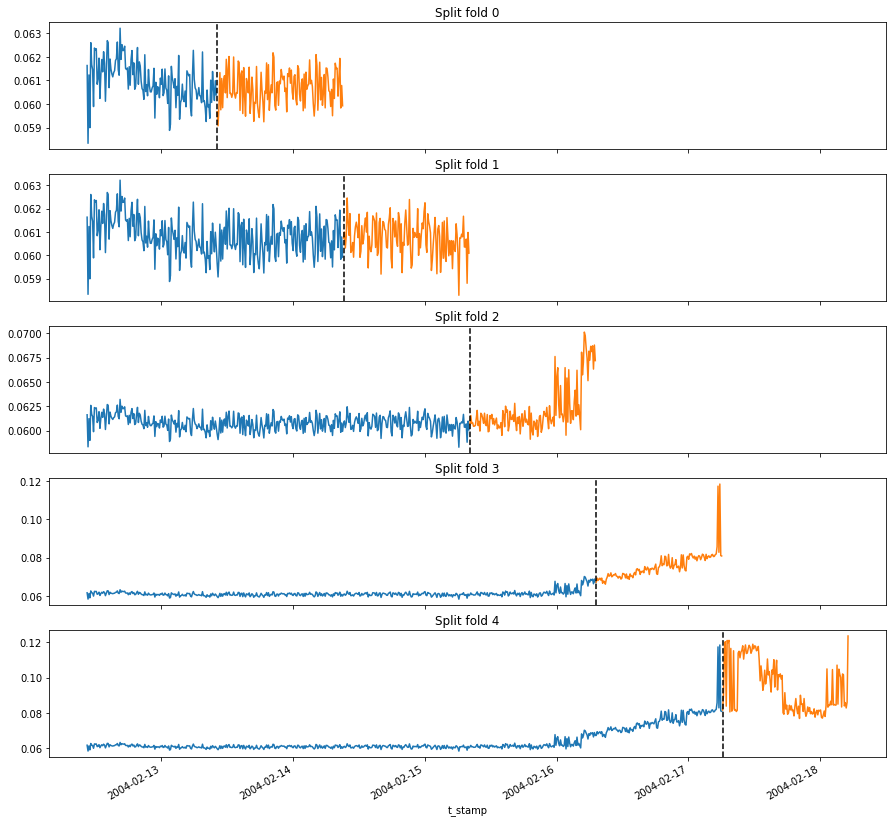

In [461]:
ts_split = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

fig, ax = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold= 0

for train_index, test_index in ts_split.split(df_pre_falha_xgb):
    train = df_pre_falha_xgb.iloc[train_index]
    test = df_pre_falha_xgb.iloc[test_index]

    train['bearing_1'].plot(ax=ax[fold],
                            label='Treino',
                            title='Split fold {}'.format(fold))

    test['bearing_1'].plot(ax=ax[fold],
                           label='Test')
    
    ax[fold].axvline(test.index.min(),
                     color='k',
                     ls='--')

    fold += 1

In [462]:
fold = 0
preds = []
scores = []

for train_index, test_index in ts_split.split(df_pre_falha_xgb):
    train = df_pre_falha_xgb.iloc[train_index]
    test = df_pre_falha_xgb.iloc[test_index]

    train = create_features(train)
    test = create_features(test)

    features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
    target = ['bearing_1']

    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]

    reg = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train,
            y_train,
            eval_set=[(X_train, y_train),
                      (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:0.434669	validation_1-rmse:0.434953
[100]	validation_0-rmse:0.160233	validation_1-rmse:0.160517
[200]	validation_0-rmse:0.059072	validation_1-rmse:0.059354
[300]	validation_0-rmse:0.021791	validation_1-rmse:0.02207
[400]	validation_0-rmse:0.008075	validation_1-rmse:0.008343
[500]	validation_0-rmse:0.003082	validation_1-rmse:0.003339
[600]	validation_0-rmse:0.001343	validation_1-rmse:0.001613
[700]	validation_0-rmse:0.000854	validation_1-rmse:0.001087
[800]	validation_0-rmse:0.000762	validation_1-rmse:0.000944
[900]	validation_0-rmse:0.000749	validation_1-rmse:0.000903
[999]	validation_0-rmse:0.000747	validation_1-rmse:0.000891
[0]	validation_0-rmse:0.434792	validation_1-rmse:0.434868
[100]	validation_0-rmse:0.159723	validation_1-rmse:0.159799
[200]	validation_0-rmse:0.058679	validation_1-rmse:0.058755
[300]	validation_0-rmse:0.02157	validation_1-rmse:0.021644
[400]	validation_0-rmse:0.007961	validation_1-rmse:0.008031
[500]	validation_0-rmse:0.003019	validation_1-

In [463]:
print('Score across folds: {:.4f}'.format(np.mean(scores)))

print('Fold scores: {}'.format(scores))

Score across folds: 0.0072
Fold scores: [0.0008911625399070132, 0.0007645965397027302, 0.0027706775694052942, 0.011947807009910678, 0.019483173169291525]


## Forecasting

In [464]:
df_pre_falha_xgb = create_features(df_pre_falha_xgb)

features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
target = ['bearing_1']

X_all = df_pre_falha_xgb[features]
y_all = df_pre_falha_xgb[target]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.01)

reg.fit(X_all,
        y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:0.426807
[100]	validation_0-rmse:0.156747
[200]	validation_0-rmse:0.057855
[300]	validation_0-rmse:0.021701
[400]	validation_0-rmse:0.008785
[500]	validation_0-rmse:0.004678
[600]	validation_0-rmse:0.003723
[700]	validation_0-rmse:0.003549
[800]	validation_0-rmse:0.003526
[900]	validation_0-rmse:0.003522
[999]	validation_0-rmse:0.003522


XGBRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000,
             objective='reg:squarederror')

In [465]:
futuro = pd.date_range(df_pre_falha_xgb.index[-1], df_rolamento.index[-1], freq='10min')

df_futuro = pd.DataFrame(index=futuro)

df_futuro['futuro'] = True

df_pre_falha_xgb['futuro'] = False

df_pred = pd.concat([df_pre_falha_xgb, df_futuro])

df_pred = create_features(df_pred)

df_pred

,bearing_1,hour,dayofweek,quarter,month,year,dayofyear,futuro
2004-02-12 10:32:39,0.061630,10,3,1,10,2004,43,False
2004-02-12 10:42:39,0.058333,10,3,1,10,2004,43,False
2004-02-12 10:52:39,0.061231,10,3,1,10,2004,43,False
2004-02-12 11:02:39,0.058995,11,3,1,11,2004,43,False
2004-02-12 11:12:39,0.062599,11,3,1,11,2004,43,False
...,...,...,...,...,...,...,...,...
2004-02-19 05:42:39,NaN,5,3,1,5,2004,50,True
2004-02-19 05:52:39,NaN,5,3,1,5,2004,50,True
2004-02-19 06:02:39,NaN,6,3,1,6,2004,50,True
2004-02-19 06:12:39,NaN,6,3,1,6,2004,50,True


<AxesSubplot:title={'center':'Previsão de valores'}>

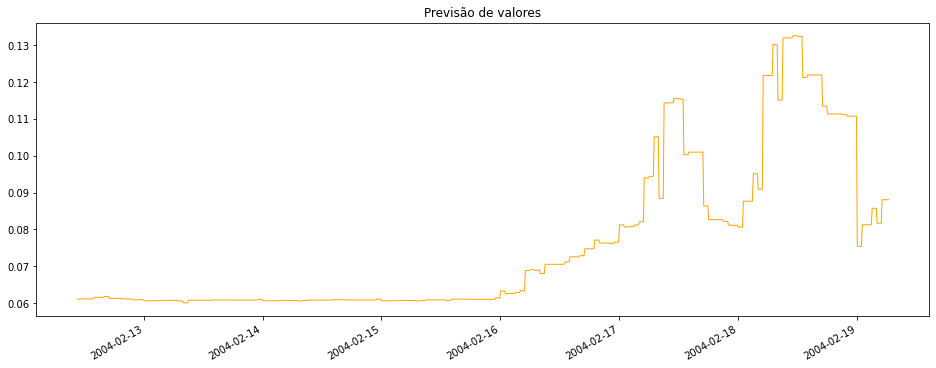

In [466]:
df_pred['bearing_pred'] = reg.predict(df_pred[features])

df_pred['bearing_pred'].plot(figsize=(16, 6),
                             color='orange',
                             ms=1,
                             lw=1,
                             title='Previsão de valores')

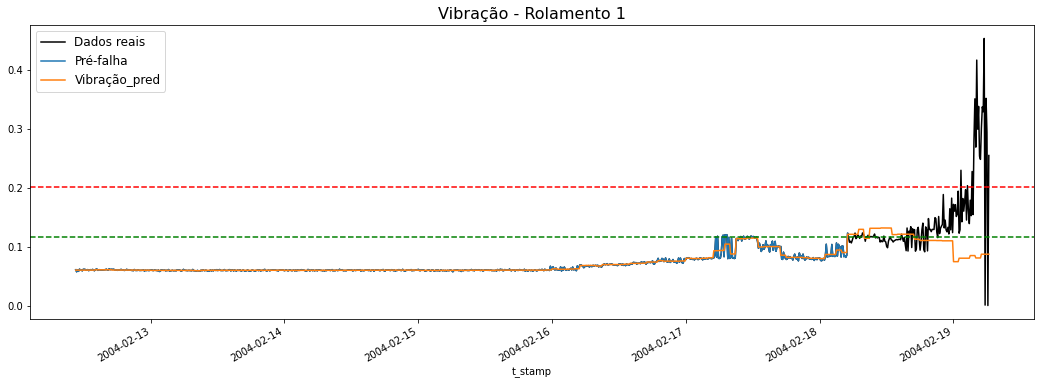

In [467]:
fig, ax = plt.subplots(figsize=(18, 6))

df_rolamento.plot(ax=ax, color='k')

df_pred['bearing_1'].plot(ax=ax)

df_pred['bearing_pred'].plot(ax=ax)

ax.legend(labels=['Dados reais', 'Pré-falha', 'Vibração_pred'], fontsize=12)

ax.set_title(label='Vibração - Rolamento 1', fontsize=16)

ax.axhline(lim_sup_sigma, color='r', linestyle='--')

ax.axhline(lim_sup_boxplot, color='green', linestyle='--')

## Mean absolute percentage error

In [468]:
# MAPE output is non-negative floating point
# The best value is 0.0

mape = mean_absolute_percentage_error(df_rolamento['bearing_1'], df_pred['bearing_pred'][:-1])

mape = mape * 100

print('MAPE = {:.2f}%'.format(mape))

MAPE = 17.75%


# SKTime

In [469]:
df_pre_falha.index = pd.DatetimeIndex(df_pre_falha.index,
                                      freq='10min')

# + dt.timedelta(minutes=10)

fh = ForecastingHorizon(pd.date_range(df_pre_falha.index[-36],
                                      periods=36,
                                      freq='10T'),
                        is_relative=False)

In [470]:
# cutoff = pd.Period(pd.to_datetime(df_pre_falha.index[-1]), freq='10T')

## Train test split

In [471]:
y_train, y_test = temporal_train_test_split(df_pre_falha, fh=fh)

In [472]:
forecaster_drift = NaiveForecaster(strategy='drift')

forecaster_drift.fit(y_train)

y_pred_drift = forecaster_drift.predict(fh)

In [473]:
forecaster_mean = NaiveForecaster(strategy='mean')

forecaster_mean.fit(y_train)

y_pred_mean = forecaster_mean.predict(fh)

In [474]:
forecaster_last = NaiveForecaster(strategy='last')

forecaster_last.fit(y_train)

y_pred_last = forecaster_last.predict(fh)

(12465.0, 12466.498715277778)

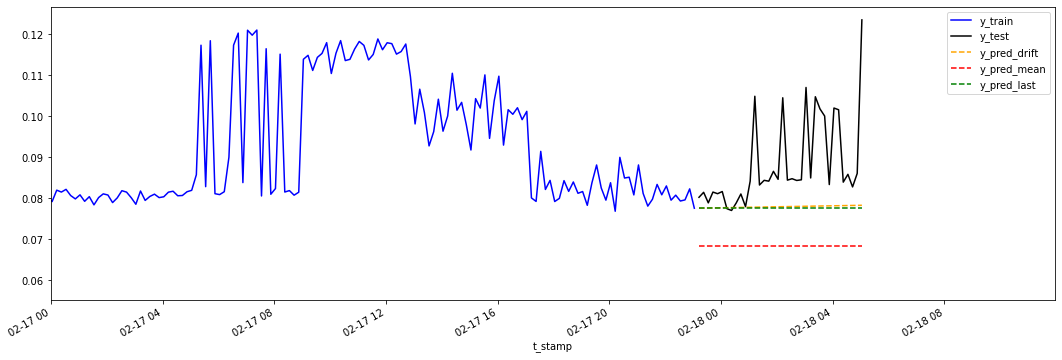

In [475]:
fig, ax = plt.subplots(figsize=(18, 6))

y_train.plot(ax=ax, color='blue')

y_test.plot(ax=ax, color='k')

y_pred_drift.plot(ax=ax, color='orange', linestyle='dashed')

y_pred_mean.plot(ax=ax, color='red', linestyle='dashed')

y_pred_last.plot(ax=ax, color='green', linestyle='dashed')

ax.legend(labels=['y_train', 'y_test', 'y_pred_drift', 'y_pred_mean', 'y_pred_last'])

ax.set_xlim(pd.to_datetime('2004-02-17'))

## Mean absolute percentage error

MAPE output is non-negative floating point
The best value is 0.0

In [476]:
mape = mean_absolute_percentage_error(y_test, y_pred_drift)

mape = mape * 100

print('MAPE = {:.2f}%'.format(mape))

MAPE = 10.71%


In [477]:
mape = mean_absolute_percentage_error(y_test, y_pred_mean)

mape = mape * 100

print('MAPE = {:.2f}%'.format(mape))

MAPE = 21.67%


In [478]:
mape = mean_absolute_percentage_error(y_test, y_pred_last)

mape = mape * 100

print('MAPE = {:.2f}%'.format(mape))

MAPE = 11.09%


# AutoARIMA com SKTime

In [ ]:
forecaster = AutoARIMA()

forecaster.fit(y_train)

y_pred_autoarima = forecaster.predict(fh)

(12465.0, 12466.498715277778)

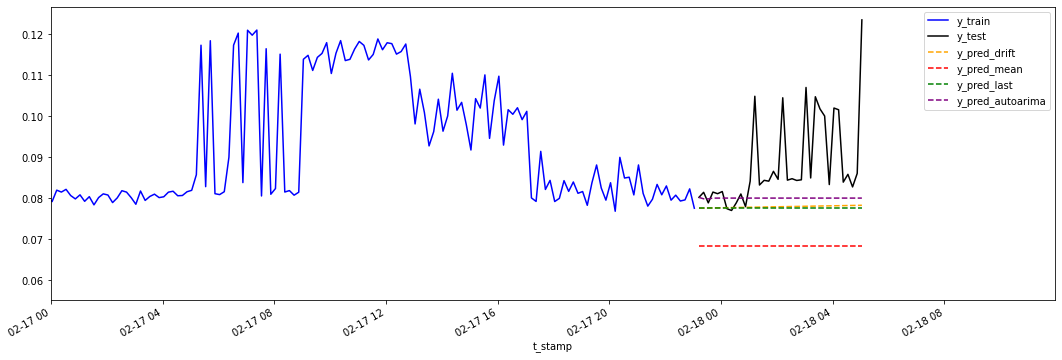

In [480]:
fig, ax = plt.subplots(figsize=(18, 6))

y_train.plot(ax=ax, color='blue')

y_test.plot(ax=ax, color='k')

y_pred_drift.plot(ax=ax, color='orange', linestyle='dashed')

y_pred_mean.plot(ax=ax, color='red', linestyle='dashed')

y_pred_last.plot(ax=ax, color='green', linestyle='dashed')

y_pred_autoarima.plot(ax=ax, color='purple', linestyle='dashed')

ax.legend(labels=['y_train',
                  'y_test',
                  'y_pred_drift',
                  'y_pred_mean',
                  'y_pred_last',
                  'y_pred_autoarima'])

ax.set_xlim(pd.to_datetime('2004-02-17'))

## Mean absolute percentage error

MAPE output is non-negative floating point
The best value is 0.0

In [483]:
mape = mean_absolute_percentage_error(y_test, y_pred_autoarima)

mape = mape * 100

print('MAPE = {:.2f}%'.format(mape))

MAPE = 8.92%
